**K-NN Regressor**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

# Datos de ejemplo: edad y altura de personas en una fiesta
# [edad, altura]
X_train = np.array([[25, 1.70], [30, 1.85], [32, 1.75], [40, 1.68], [28, 1.80], [35, 1.72]])
y_train = np.array([65, 80, 70, 60, 75, 68]) # Su peso en kg

# Nuevo invitado
invitado_nuevo = np.array([[31, 1.78]])

In [ ]:
# Creamos el modelo y lo entrenamos (en K-NN es solo almacenar los datos)
k = 2
knn = KNeighborsRegressor(n_neighbors=k)
knn.fit(X_train, y_train)

# Hacemos la predicción para el nuevo invitado
peso_predicho = knn.predict(invitado_nuevo)

print(f"El peso predicho para el nuevo invitado es: {peso_predicho[0]:.2f} kg.")

El peso predicho para el nuevo invitado es: 75.00 kg.


**Mínimos Cuadrados Parciales (PLS)**


In [ ]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split

# Datos de ejemplo con multicolinealidad
# x1 y x2 están altamente correlacionadas
X = np.random.rand(50, 2)
X[:, 1] = X[:, 0] + np.random.normal(0, 0.1, 50) # x2 es casi igual a x1

# y = 2*x1 + 3*x2 + ruido
y = 2 * X[:, 0] + 3 * X[:, 1] + np.random.normal(0, 0.5, 50)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Creamos y entrenamos el modelo PLS
pls = PLSRegression(n_components=1) # Usamos un solo componente latente para simplificar
pls.fit(X_train, y_train)

# Hacemos una predicción y mostramos el score
score = pls.score(X_test, y_test)
print(f"R-cuadrado del modelo PLS: {score:.2f}")

R-cuadrado del modelo PLS: 0.91


**Regresión Bayesiana**

In [ ]:
# Instala la biblioteca PyMC
!pip install pymc
# Importa las bibliotecas necesarias
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Creamos un DataFrame con datos de ejemplo
data = {
    'distancia_km': [5, 10, 15, 20, 25, 30, 35, 40, 5, 10, 15, 20],
    'tipo_via': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1], # 0 = calle, 1 = autopista
    'tiempo_min': [15, 25, 30, 40, 55, 60, 70, 80, 5, 10, 15, 20]
}
df = pd.DataFrame(data)
print(df)

    distancia_km  tipo_via  tiempo_min
0              5         0          15
1             10         0          25
2             15         0          30
3             20         0          40
4             25         0          55
5             30         0          60
6             35         0          70
7             40         0          80
8              5         1           5
9             10         1          10
10            15         1          15
11            20         1          20


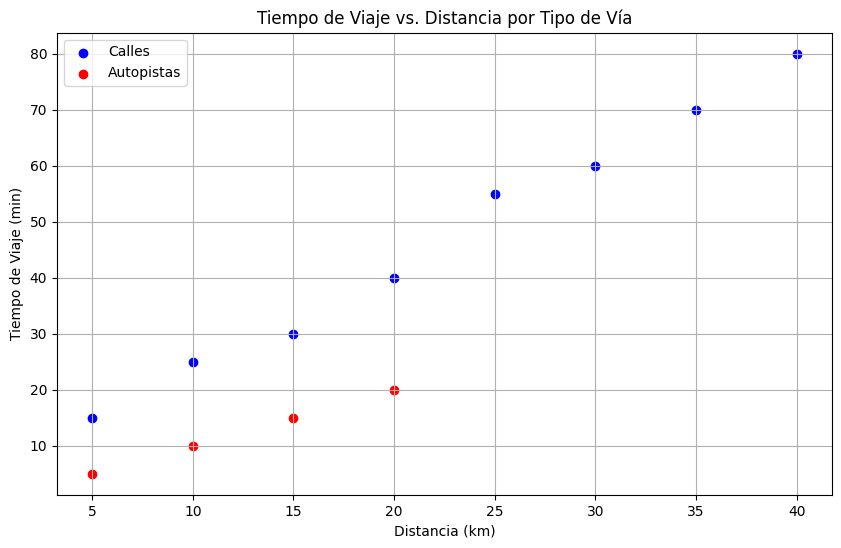

In [ ]:
# Graficamos los datos para visualizarlos
plt.figure(figsize=(10, 6))
plt.scatter(df[df['tipo_via'] == 0]['distancia_km'], df[df['tipo_via'] == 0]['tiempo_min'], color='blue', label='Calles')
plt.scatter(df[df['tipo_via'] == 1]['distancia_km'], df[df['tipo_via'] == 1]['tiempo_min'], color='red', label='Autopistas')
plt.xlabel('Distancia (km)')
plt.ylabel('Tiempo de Viaje (min)')
plt.title('Tiempo de Viaje vs. Distancia por Tipo de Vía')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
with pm.Model() as bayesian_model:
    # Priors (creencias iniciales sobre los parámetros)
    # Elegimos distribuciones Normal para los coeficientes y una distribución HalfNormal para sigma (porque no puede ser negativa)
    beta_distancia = pm.Normal('beta_distancia', mu=0, sigma=10)
    beta_via = pm.Normal('beta_via', mu=0, sigma=10)
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # La media esperada del tiempo de viaje
    mu = intercept + beta_distancia * df['distancia_km'] + beta_via * df['tipo_via']

    # La verosimilitud (cómo nuestros datos encajan en el modelo)
    tiempo_obs = pm.Normal('tiempo_obs', mu=mu, sigma=sigma, observed=df['tiempo_min'])

In [ ]:
with bayesian_model:
    # Realizamos el muestreo para obtener las distribuciones de los parámetros
    trace = pm.sample(2000, tune=1000, cores=2)

Output()

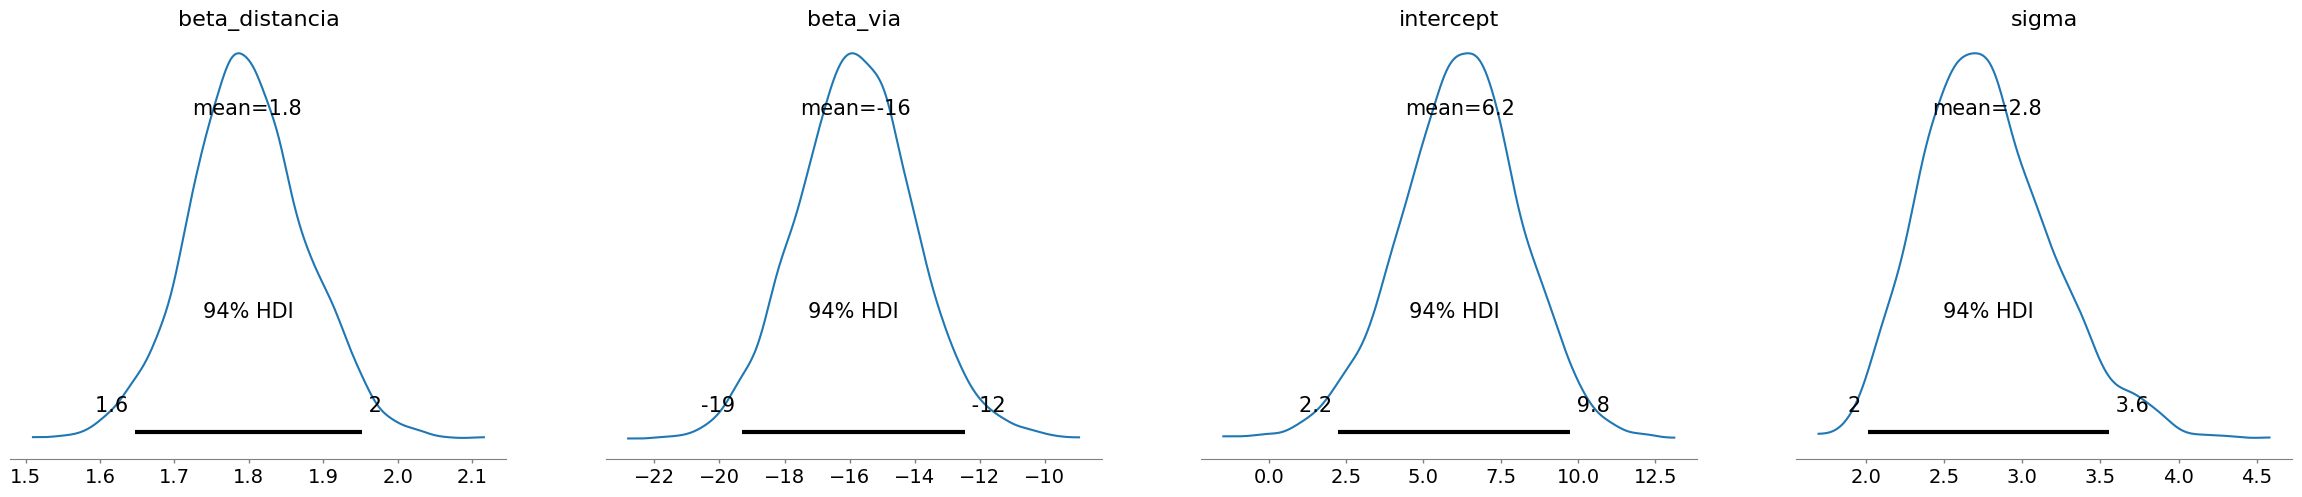

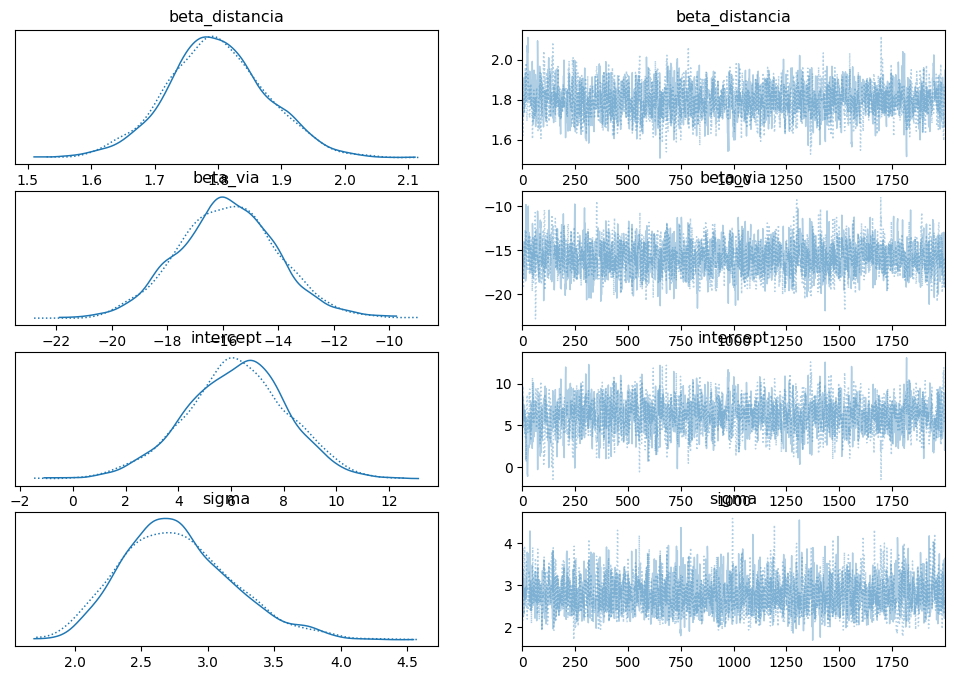

In [ ]:
# Mostramos un resumen de los resultados
pm.summary(trace)

# Visualizamos las distribuciones de los parámetros
pm.plot_posterior(trace)
plt.show()

# También podemos ver las "trazas" o cadenas de muestreo, para asegurarnos de que el muestreo fue bien
pm.plot_trace(trace)
plt.show()

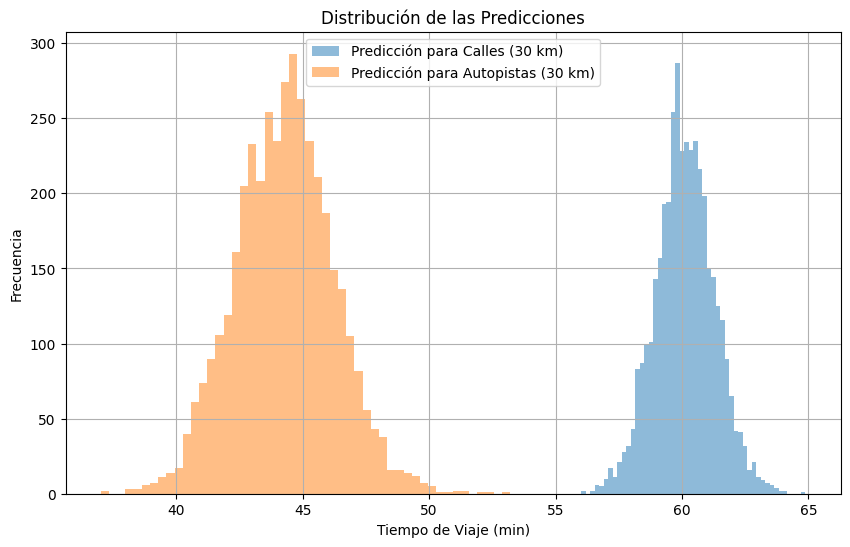

Predicción para 30 km en Calles:
Media: 60.11 min
Intervalo de confianza del 95%: [57.77, 62.45] min

Predicción para 30 km en Autopistas:
Media: 44.29 min
Intervalo de confianza del 95%: [40.55, 48.14] min


In [ ]:
# Definimos nuevos datos para predecir
new_data = {
    'distancia_km': [30, 30],
    'tipo_via': [0, 1]
}
new_df = pd.DataFrame(new_data)

# Extraemos las muestras de la traza para hacer predicciones
beta_distancia_samples = trace.posterior['beta_distancia'].values.flatten()
beta_via_samples = trace.posterior['beta_via'].values.flatten()
intercept_samples = trace.posterior['intercept'].values.flatten()

# Creamos una función de predicción
def predict_time(distance, via, intercept, beta_distancia, beta_via):
    return intercept + beta_distancia * distance + beta_via * via

# Realizamos predicciones para cada nuevo punto de dato
predictions_calle = predict_time(new_df.iloc[0]['distancia_km'], new_df.iloc[0]['tipo_via'], intercept_samples, beta_distancia_samples, beta_via_samples)
predictions_autopista = predict_time(new_df.iloc[1]['distancia_km'], new_df.iloc[1]['tipo_via'], intercept_samples, beta_distancia_samples, beta_via_samples)

# Visualizamos las distribuciones de las predicciones
plt.figure(figsize=(10, 6))
plt.hist(predictions_calle, bins=50, alpha=0.5, label='Predicción para Calles (30 km)')
plt.hist(predictions_autopista, bins=50, alpha=0.5, label='Predicción para Autopistas (30 km)')
plt.xlabel('Tiempo de Viaje (min)')
plt.ylabel('Frecuencia')
plt.title('Distribución de las Predicciones')
plt.legend()
plt.grid(True)
plt.show()

# Y mostramos las estadísticas principales de las predicciones
print("Predicción para 30 km en Calles:")
print(f"Media: {np.mean(predictions_calle):.2f} min")
print(f"Intervalo de confianza del 95%: [{np.percentile(predictions_calle, 2.5):.2f}, {np.percentile(predictions_calle, 97.5):.2f}] min")

print("\nPredicción para 30 km en Autopistas:")
print(f"Media: {np.mean(predictions_autopista):.2f} min")
print(f"Intervalo de confianza del 95%: [{np.percentile(predictions_autopista, 2.5):.2f}, {np.percentile(predictions_autopista, 97.5):.2f}] min")